# Autoencoders, data projection and investigating a learned NN

0. Basics

 - Imports
 - Import and normalize Mnist data
***
1. Learning Representation with Autoencoders (partial import from keras blog)

 - Standard Autoencoder
 - Variants of autoencoders
 - Variational autoencoders
 - Deep autoencoders
***
2. Using Autoencoders for projecting data in a 2D plot 
***
3. Identifying the input in the training set that most activates a hidden unit
***
4. Finding stimulus that fires most a hidden neuron by gradient descent
***
5. Denoising images
***
6. Comparing variants of autoencoders as preprocessing models

## 0. Basics

### Imports


In [12]:
from __future__ import absolute_import
from __future__ import print_function
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['axes.axisbelow'] = True

import tensorflow as tf
from keras.datasets import mnist
from keras import objectives
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda, GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

### Importing a predefined dataset (and normalizing it)

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
nb_classes = 10
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
y_train =  np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
print(X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


## 1. Learning Representation with Autoencoders (partial import from keras blog)

### Standard Autoencoder 


In [6]:
# our input has a dim of 784
input_img = Input(shape=(784,))
# compression of factor 24.5
encoding_dim = 32
# encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
# lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)
# this model maps an input to its encoded representation
encoder = Model(inputs=input_img, outputs=encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [7]:
autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
h = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    verbose=0,
    validation_data=(X_test, X_test)
)

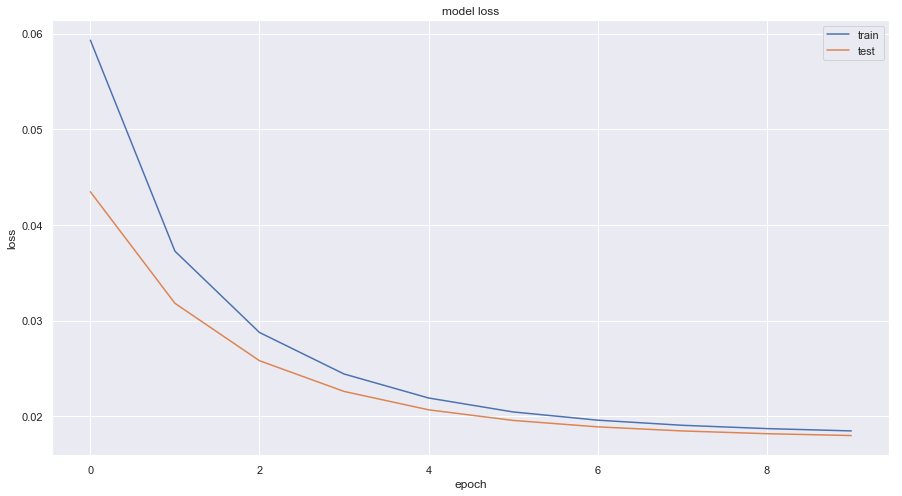

In [9]:
history = h 
# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### Looking to reconstructed data

In [10]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

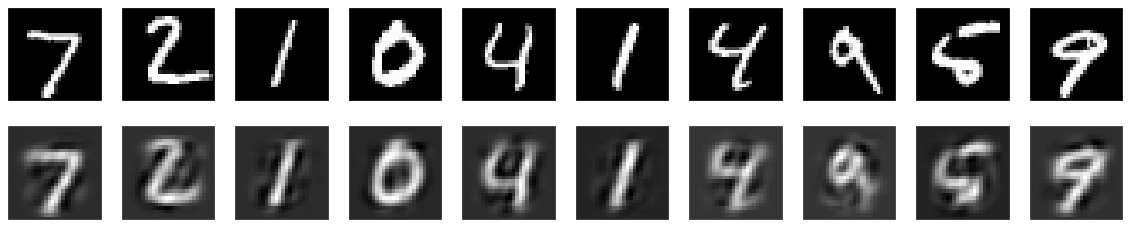

In [13]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### Plot reconstructed data for different learning iteration numbers

learning iteration numbers = 1


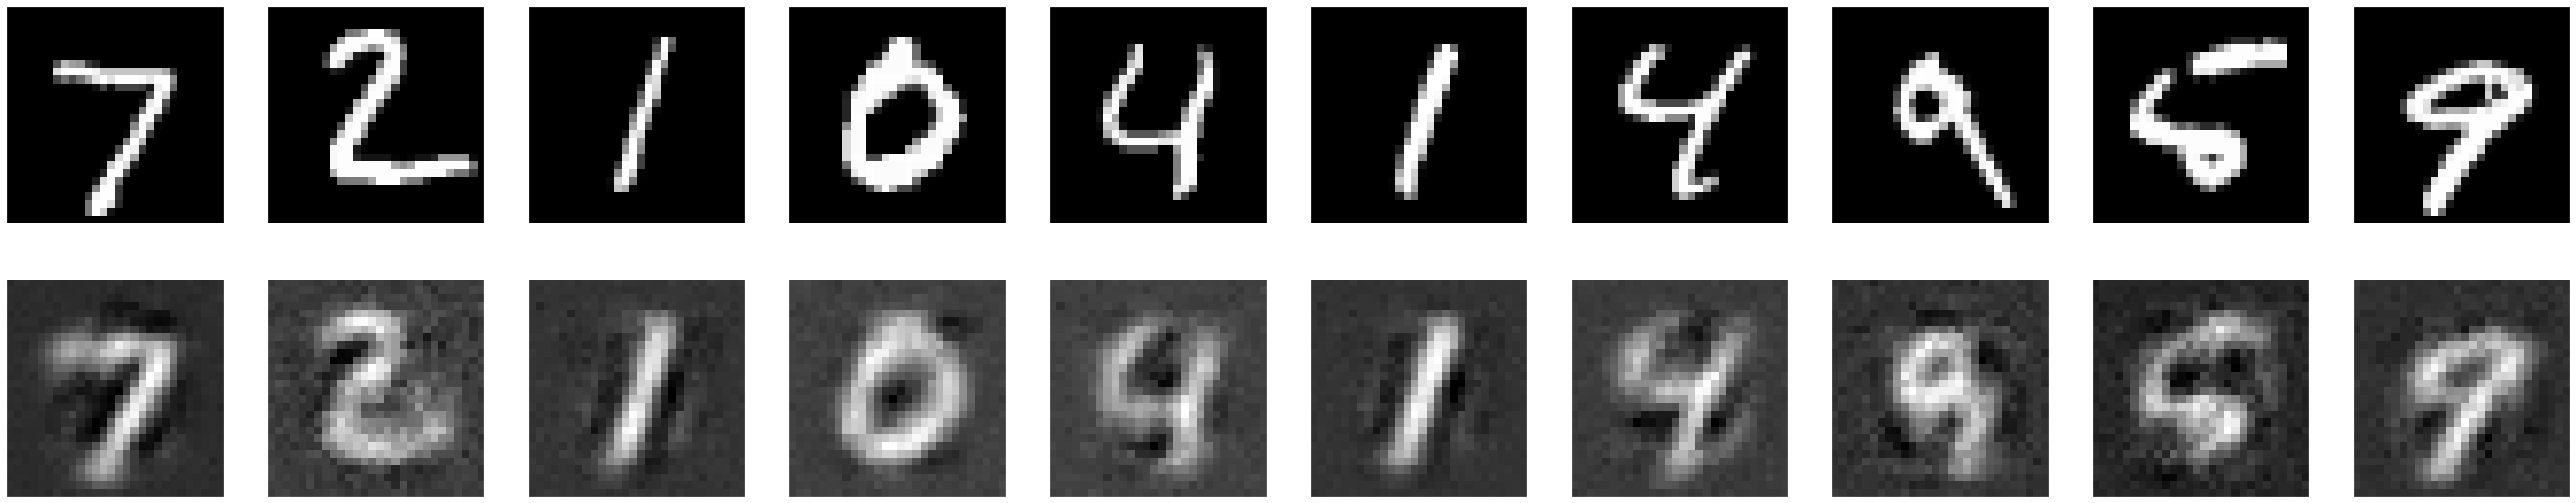

learning iteration numbers = 5


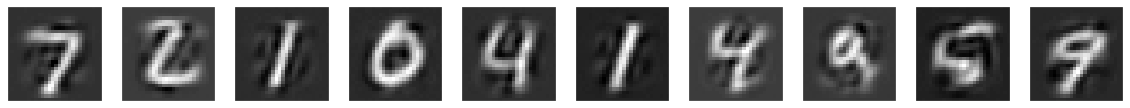

learning iteration numbers = 10


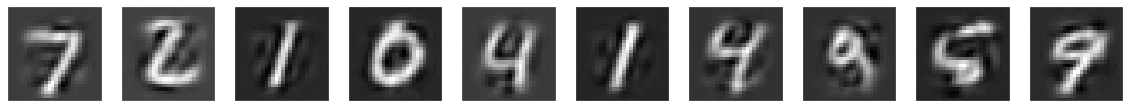

learning iteration numbers = 20


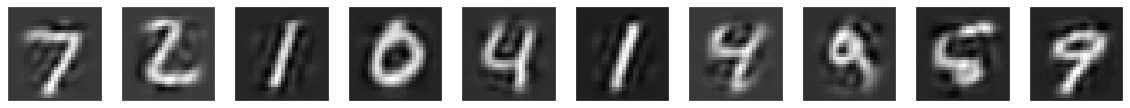

<Figure size 1440x288 with 0 Axes>

In [14]:
iterations = [1, 5, 10, 20]
n = 10  # how many digits we will display
plt.figure(figsize=((len(iterations)+1)*10, 2*(len(iterations)+1)))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
       
encoding_dim = 50
   
for it in iterations:
    print ("learning iteration numbers = {}".format(it))
    input_img = Input(shape=(784,))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='linear')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adam', loss='mse')

    h = autoencoder.fit(
        X_train, X_train,
        epochs=it,
        batch_size=256,
        verbose=0,
        shuffle=True,
        validation_data=(X_test, X_test)
    )
    #encode  
    encoded_imgs = encoder.predict(X_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    for i in range(n):
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.figure(figsize=(20, 4))

#### Exploring learned filters

In [15]:
W_Input2Hidden = autoencoder.get_weights()[0]
print(W_Input2Hidden.shape)

(784, 50)


In [16]:
def displayFilters(model, nfiltres, name):
    W_Input2Hidden = autoencoder.get_weights()[0]
    fig = plt.figure(figsize=(15, 20))
    plt.savefig(name) 
    for i in range(nfiltres):
        ax = plt.subplot(nfiltres/5+1, 5 , (i+1))
        plt.imshow(W_Input2Hidden[:,i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()  
    plt.close(fig)

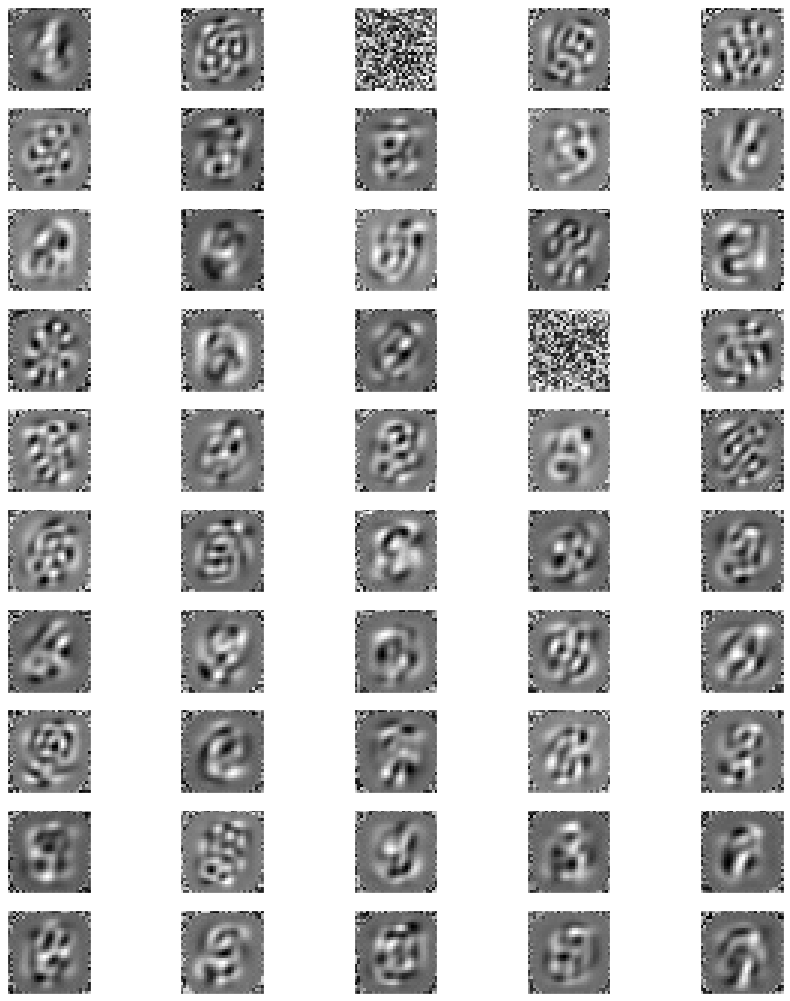

In [17]:
displayFilters(autoencoder, encoding_dim, "Standard")

### 1.2 Variants

Can you get better filters with variants of autoencoders such as the following?
- Denoising autoencoders
- Sparse autoencoders

#### Denoising Autoencoders


In [18]:
encoding_dim = 32
input_img = Input(shape=(784,))
input_img_noisy = GaussianNoise(0.01)(input_img)
encoded = Dense(encoding_dim, activation='relu')(input_img_noisy)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

####  Adding a L1 activity regularizer / Sparse autoencoder

In [19]:
encoding_dim = 32
input_img = Input(shape=(784,))
encoded = Dense(
    encoding_dim, activation='relu',
    activity_regularizer=regularizers.l1(1e-8)
)(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### 1.3 Variational Autoencoders

In [ ]:
'''
This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return(z_mean + K.exp(z_log_var / 2) * epsilon)

# note that "output_shape" isn't necessarily with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
# train the VAE on MNIST digits
"""
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
"""
print (X_train.shape)
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

ValueError: 'c' argument has 10000 elements, which is not acceptable for use with 'x' with size 10000, 'y' with size 10000.

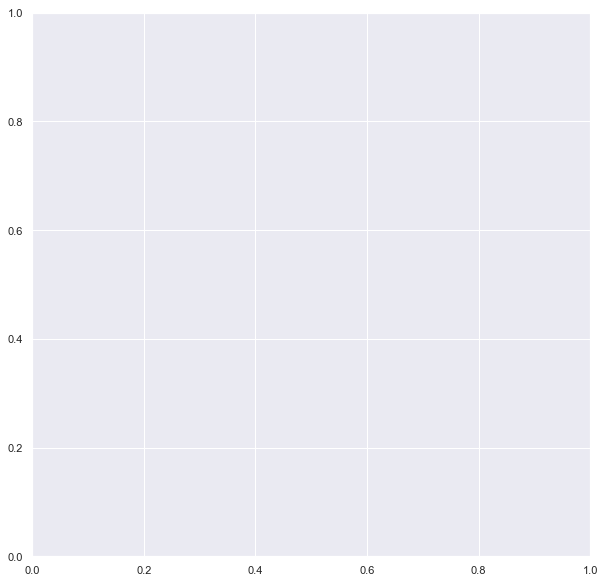

In [29]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

print (grid_x)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

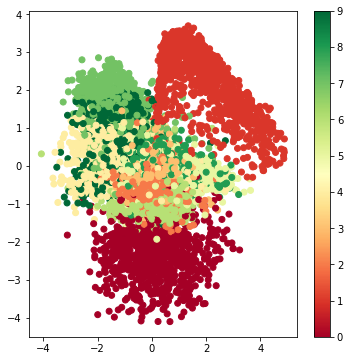

[ -1.64485363e+00  -1.20404696e+00  -9.20822976e-01  -6.97141435e-01
  -5.03965367e-01  -3.28072108e-01  -1.61844167e-01  -1.39145821e-16
   1.61844167e-01   3.28072108e-01   5.03965367e-01   6.97141435e-01
   9.20822976e-01   1.20404696e+00   1.64485363e+00]


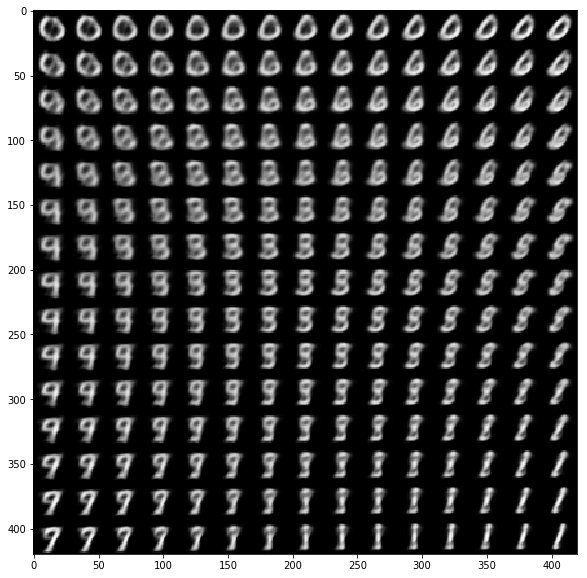

In [166]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

print (grid_x)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### 1.4 Deep autoencoder


In [30]:
#this is the size of our encoded representations
encoding_dim = 32  # of embedding size = 32 -> compression of factor 24.5, assuming the input is 784 floats
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
encodedL1 = Dense(200, activation='relu', activity_regularizer=regularizers.l1(1e-8))(input_img)
encodedL2 = Dense(50, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL1)
encodedL3 = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL2)
# "decoded" is the lossy reconstruction of the input
decoded1 = Dense(50, activation='relu')(encodedL3)
decoded2 = Dense(100, activation='relu')(decoded1)
decoded = Dense(784, activation='linear')(decoded2)
# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encodedL3)
FirstLayer = Model(input=input_img, output=encodedL1)
# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(input=encoded_input, output=decoded)

autoencoder.compile(optimizer='adadelta', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))



TypeError: _init_subclassed_network() got an unexpected keyword argument 'input'

(784, 200)


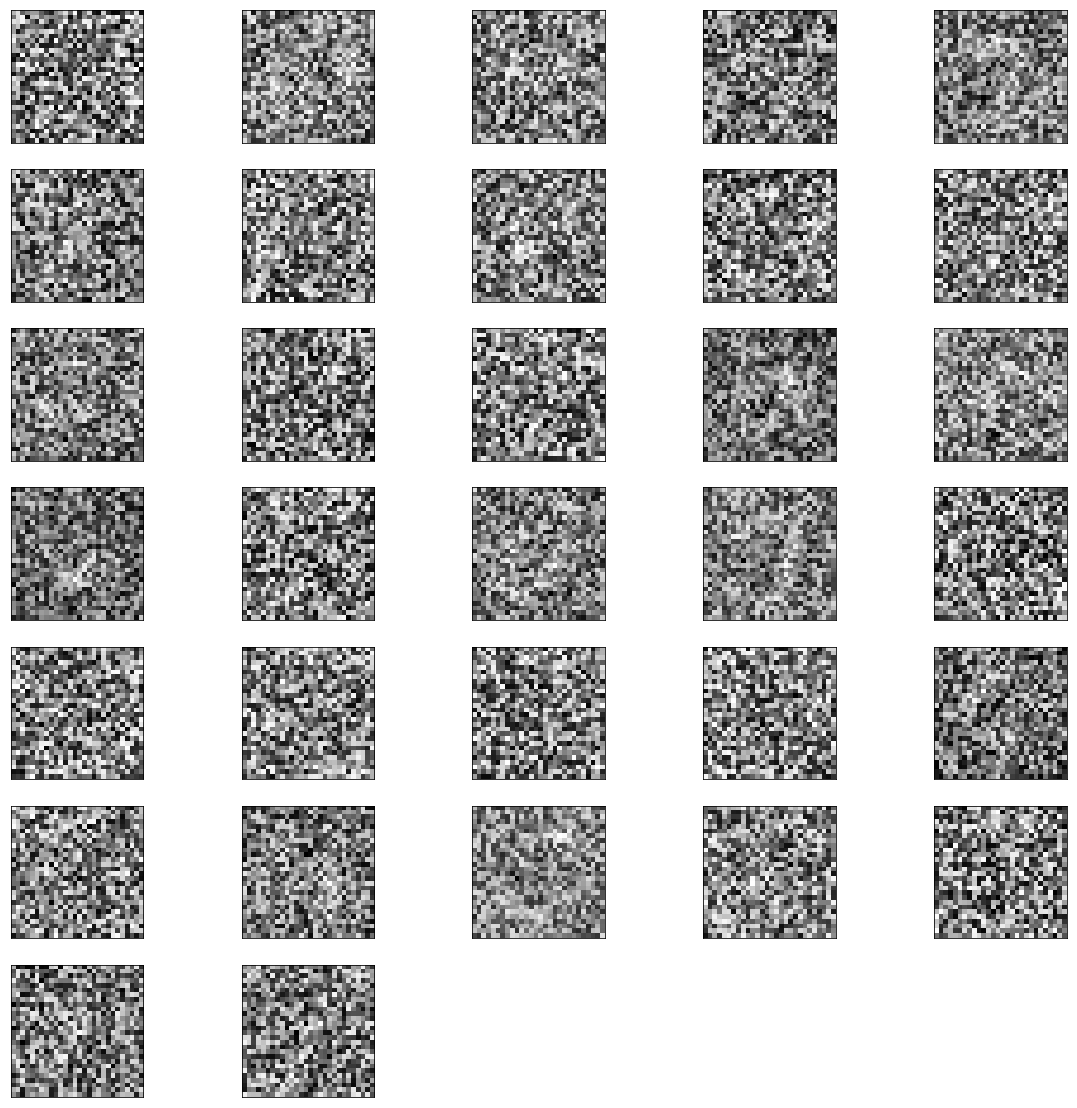

In [170]:
# Investigating first layer filters

W_Input2Hidden = autoencoder.get_weights()[0]
print (W_Input2Hidden.shape)

### Plot filters
n = encoding_dim  # how many digits we will display
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(n/5+1, 5 , (i+1))

    plt.imshow(W_Input2Hidden[:,i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

## 2. Using Autoencoders for projecting data in a 2D plot



Using autoencoders with embedding size equal to 2 you may project data nonlinearly in a latant space.

Perform such a projection with a stadard autoencoder and a deep autoencoder and plot the projected data with class numbers.

/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if __name__ == '__main__':
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  del sys.path[0]
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.0769 - val_loss: 0.0665
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.0653 - val_loss: 0.0644
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.0627 - val_loss: 0.0615
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.0605 - val_loss: 0.0598
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.0592 - val_loss: 0.0587
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.0583 - val_loss: 0.0579
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.0577 - val_loss: 0.0574
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.0572 - val_loss: 0.0569
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.0569 - val_loss: 0.0567
Epoch 10/50
60000/60000 [==============================] - 1s - loss: 0.0567 - val_loss: 0.0565

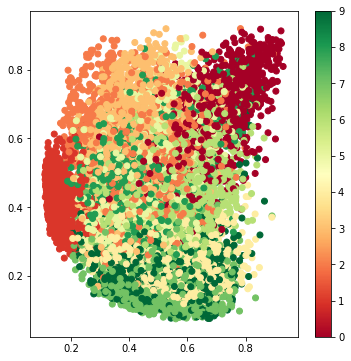

In [184]:
batch_size = 256
original_dim = 784
latent_dim = 2
nb_epoch = 50

input_img = Input(shape=(original_dim,))
encoded = Dense(latent_dim, activation='sigmoid')(input_img)
decoded = Dense(original_dim, activation='linear')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.show()

/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 0.0881 - val_loss: 0.0640
Epoch 2/100
60000/60000 [==============================] - 1s - loss: 0.0635 - val_loss: 0.0629
Epoch 3/100
60000/60000 [==============================] - 1s - loss: 0.0619 - val_loss: 0.0605
Epoch 4/100
60000/60000 [==============================] - 1s - loss: 0.0596 - val_loss: 0.0586
Epoch 5/100
60000/60000 [==============================] - 1s - loss: 0.0584 - val_loss: 0.0580
Epoch 6/100
60000/60000 [==============================] - 1s - loss: 0.0580 - val_loss: 0.0577
Epoch 7/100
60000/60000 [==============================] - 1s - loss: 0.0578 - val_loss: 0.0575
Epoch 8/100
60000/60000 [==============================] - 1s - loss: 0.0575 - val_loss: 0.0573
Epoch 9/100
60000/60000 [==============================] - 1s - loss: 0.0573 - val_loss: 0.0570
Epoch 10/100
60000/60000 [==============================] - 1s - loss: 0.0570 - val_lo

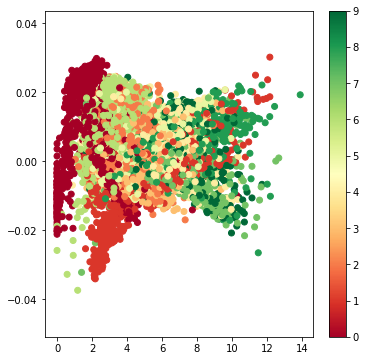

In [187]:
batch_size = 256
original_dim = 784
latent_dim = 2
nb_epoch = 100

# this is our input placeholder
input_img = Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encodedL1 = Dense(200, activation='relu', activity_regularizer=regularizers.l1(1e-8))(input_img)
encodedL2 = Dense(50, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL1)
encodedL3 = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL2)

# "decoded" is the lossy reconstruction of the input
decoded1 = Dense(50, activation='relu')(encodedL3)
decoded2 = Dense(100, activation='relu')(decoded1)
decoded = Dense(784, activation='linear')(decoded2)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encodedL3)
FirstLayer = Model(input=input_img, output=encodedL1)

autoencoder.compile(optimizer='adadelta', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))


# display a 2D plot of the digit classes in the latent space
x_test_encoded_deep = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_deep[:, 0], x_test_encoded[:, 1], c=Y_test, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.show()


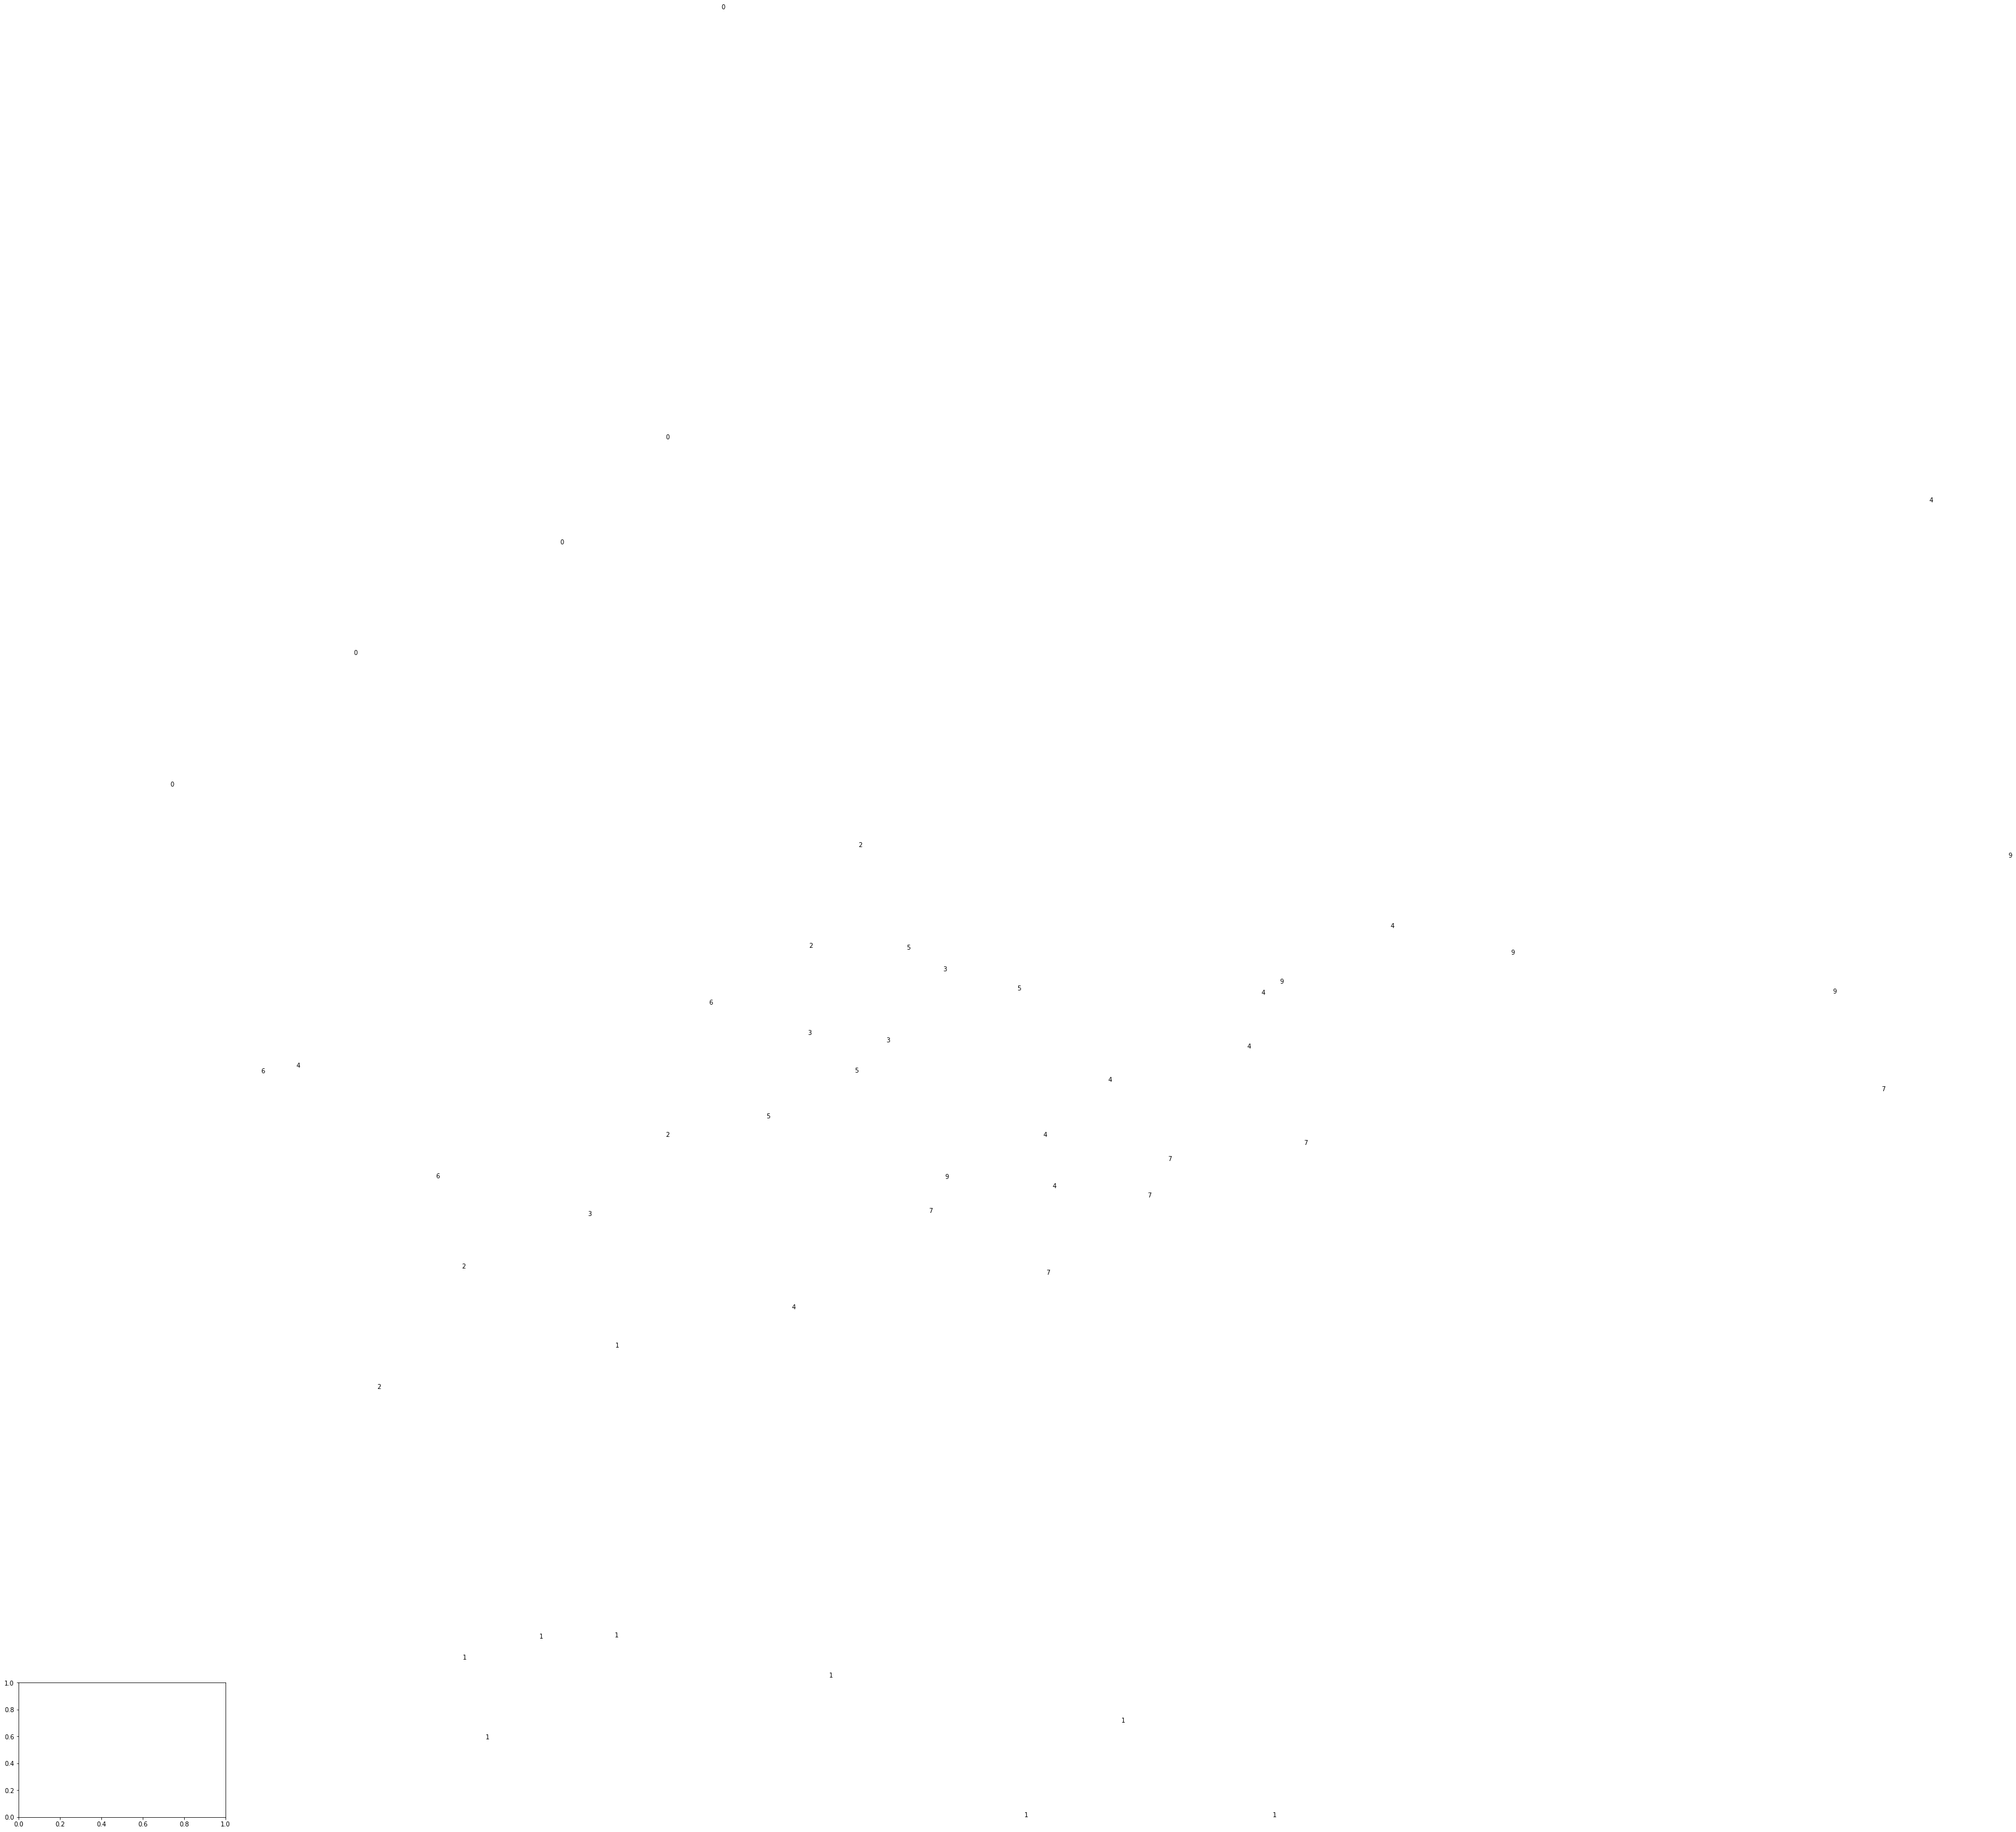

In [198]:
fig = plt.figure()
axe = fig.add_subplot(111)
for i in range(50):
    axe.text(x_test_encoded_deep[i][0], x_test_encoded_deep[i][1], '%s' %Y_test[i])
plt.show()

## 3. Identifying the input in the training set that most activates a hidden unit

A popular way to investigate what is learned by particular neurons of a neural network is to determine the input data from the trainng set that most activtates the neuron.

i/ Implement a method for investigating the computations made by hidden neurons of a deep autoencoder. It will plot for every neuron of a hidden layer the input sample that most fires the neuron.

ii/ Implement a variant where for a single hidden neuron you will plot a number (e.g. 10) of input samples that most fires the neuron 

iii/ Test your methods on a deep autoencoder learned on Mnist data.  

iv/ Test your method on hidden layers for a MLP classifier that you trained on Mnist data for TP1.


/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 0.0754 - val_loss: 0.0634
Epoch 2/100
60000/60000 [==============================] - 2s - loss: 0.0627 - val_loss: 0.0618
Epoch 3/100
60000/60000 [==============================] - 1s - loss: 0.0599 - val_loss: 0.0571
Epoch 4/100
60000/60000 [==============================] - 2s - loss: 0.0545 - val_loss: 0.0515
Epoch 5/100
60000/60000 [==============================] - 2s - loss: 0.0500 - val_loss: 0.0481
Epoch 6/100
60000/60000 [==============================] - 2s - loss: 0.0471 - val_loss: 0.0455
Epoch 7/100
60000/60000 [==============================] - 2s - loss: 0.0448 - val_loss: 0.0435
Epoch 8/100
60000/60000 [==============================] - 2s - loss: 0.0430 - val_loss: 0.0418
Epoch 9/100
60000/60000 [==============================] - 2s - loss: 0.0413 - val_loss: 0.0402
Epoch 10/100
60000/60000 [==============================] - 2s - loss: 0.0400 - val_lo

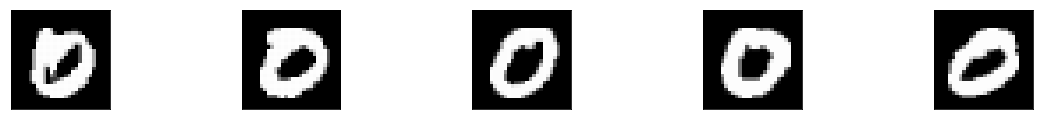

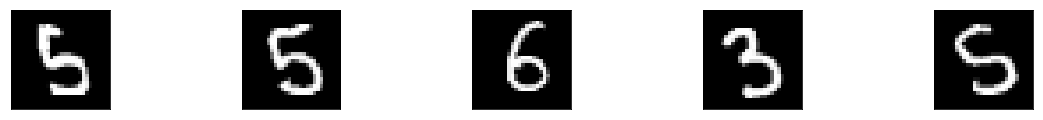

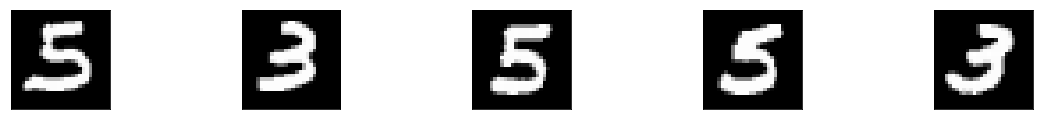

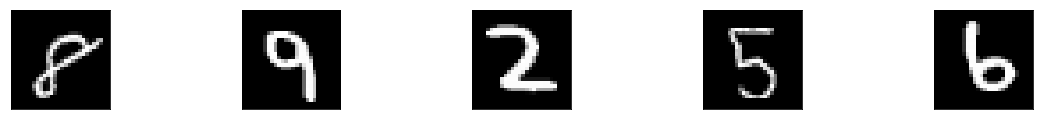

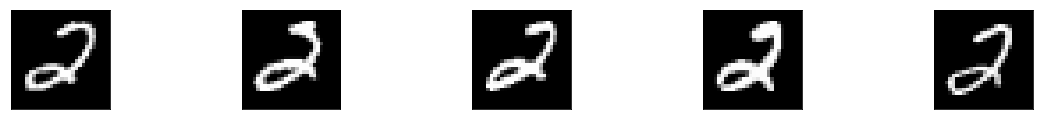

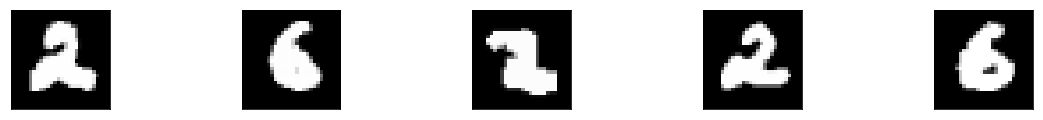

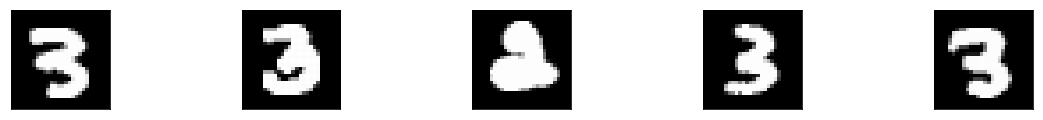

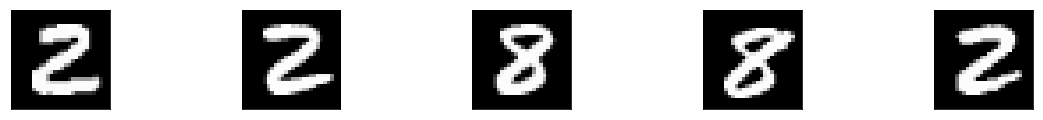

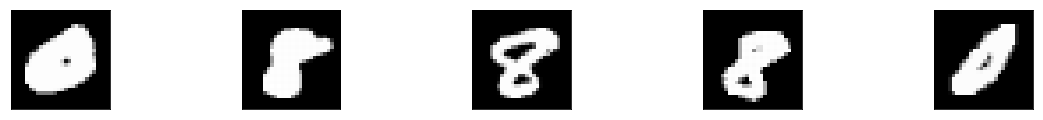

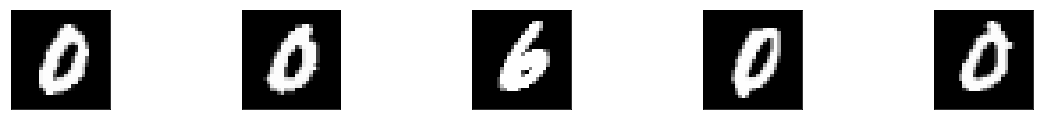

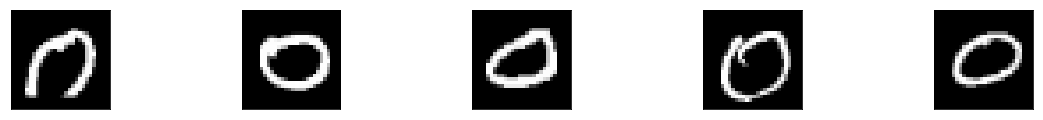

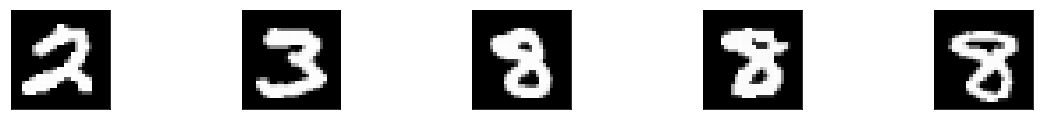

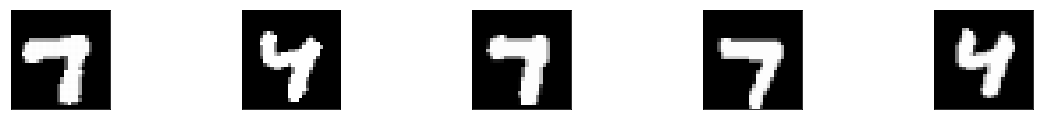

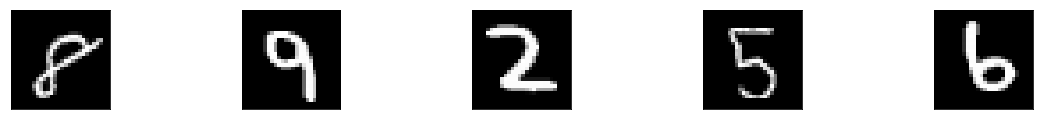

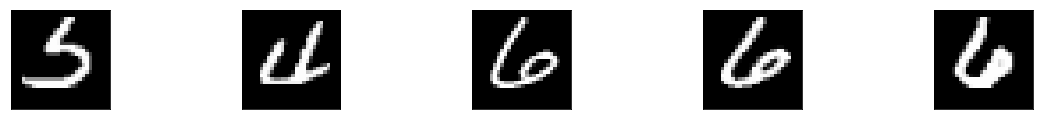

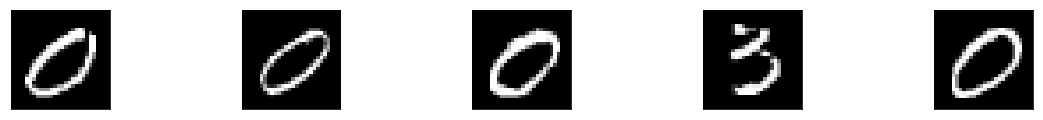

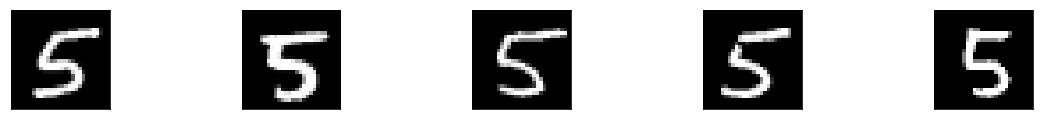

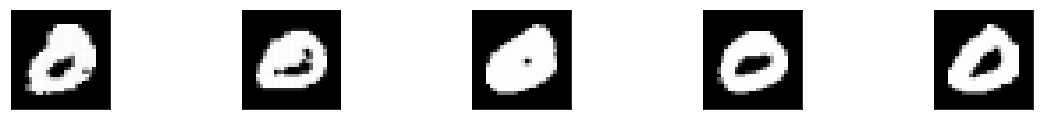

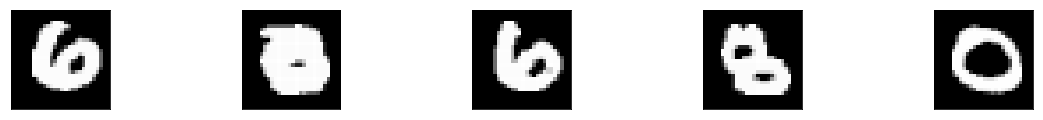

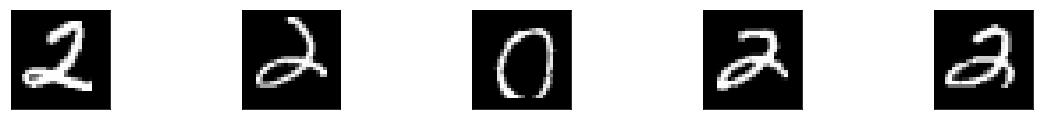

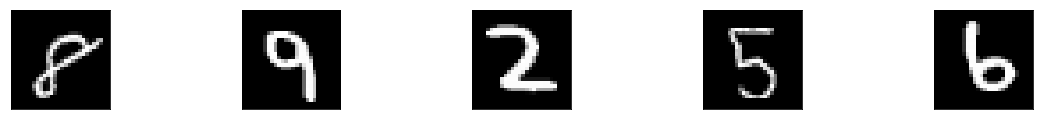

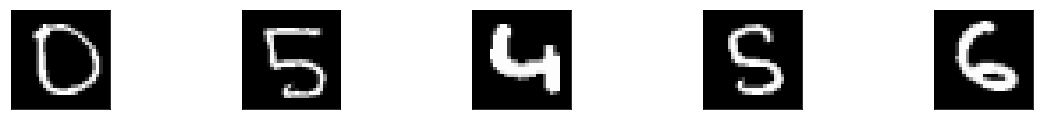

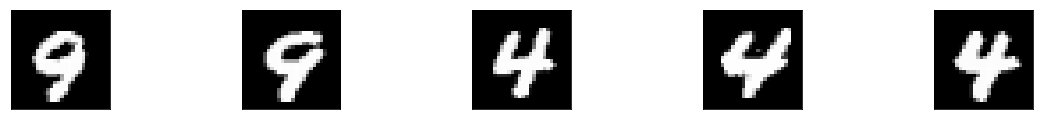

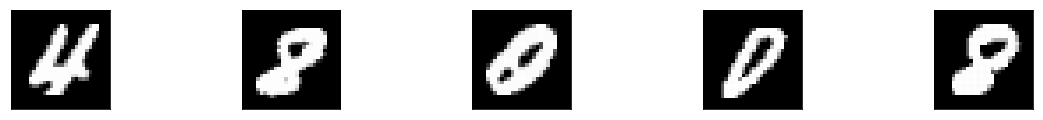

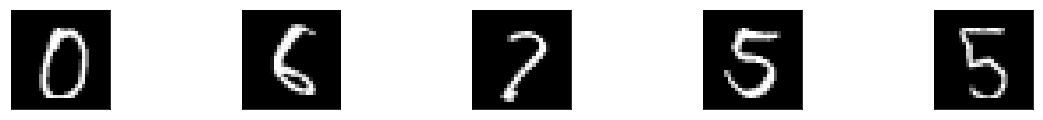

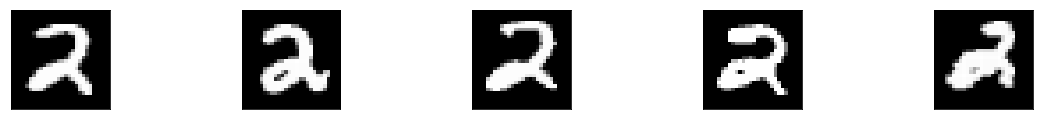

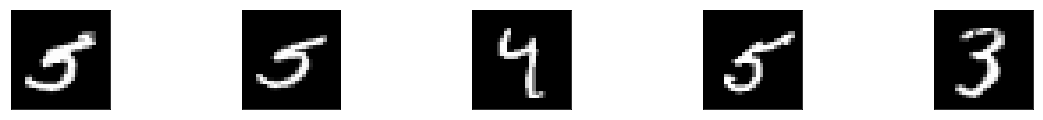

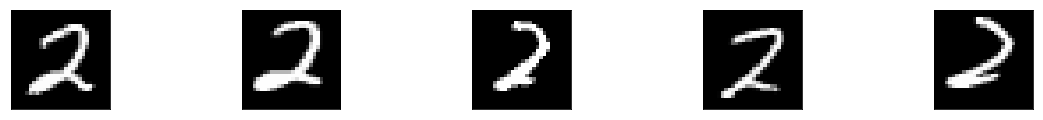

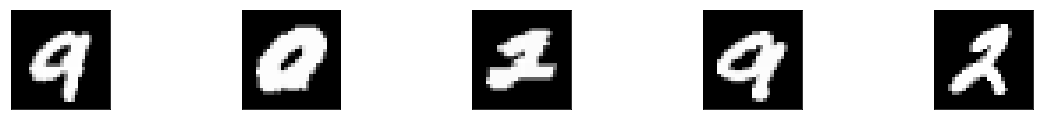

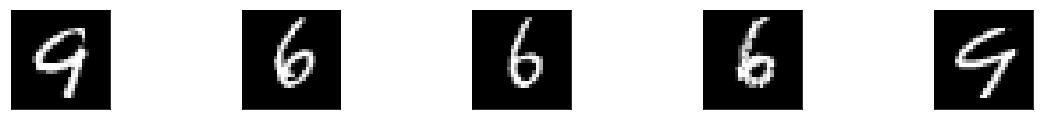

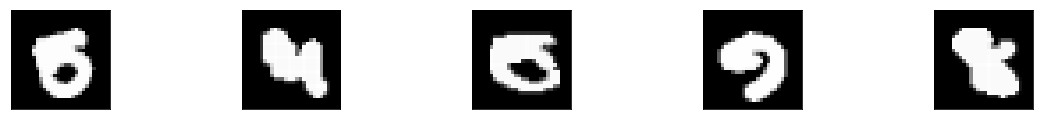

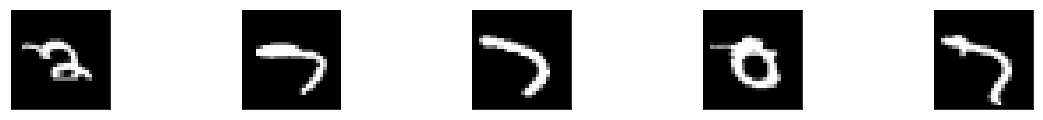

In [213]:
batch_size = 256
original_dim = 784
latent_dim = 32
nb_epoch = 100
n = 5

# this is our input placeholder
input_img = Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encodedL1 = Dense(200, activation='relu', activity_regularizer=regularizers.l1(1e-8))(input_img)
encodedL2 = Dense(50, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL1)
encodedL3 = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL2)

# "decoded" is the lossy reconstruction of the input
decoded1 = Dense(50, activation='relu')(encodedL3)
decoded2 = Dense(100, activation='relu')(decoded1)
decoded = Dense(784, activation='linear')(decoded2)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encodedL3)
FirstLayer = Model(input=input_img, output=encodedL1)

autoencoder.compile(optimizer='adadelta', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

x_train_encoded_deep = encoder.predict(x_train, batch_size=batch_size)


for neuron in range(latent_dim):
    liste = np.argsort(x_train_encoded_deep[:, neuron])
    liste = liste[::-1]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_train[liste[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()


Same work but on MNIST dataset

/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/users/usrlocal/artieres/.Virtualenvs/ENV2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 0.0794 - val_loss: 0.0633
Epoch 2/100
60000/60000 [==============================] - 2s - loss: 0.0624 - val_loss: 0.0609
Epoch 3/100
60000/60000 [==============================] - 2s - loss: 0.0586 - val_loss: 0.0556
Epoch 4/100
60000/60000 [==============================] - 2s - loss: 0.0537 - val_loss: 0.0512
Epoch 5/100
60000/60000 [==============================] - 2s - loss: 0.0496 - val_loss: 0.0472
Epoch 6/100
60000/60000 [==============================] - 2s - loss: 0.0462 - val_loss: 0.0444
Epoch 7/100
60000/60000 [==============================] - 2s - loss: 0.0439 - val_loss: 0.0427
Epoch 8/100
60000/60000 [==============================] - 2s - loss: 0.0424 - val_loss: 0.0413
Epoch 9/100
60000/60000 [==============================] - 2s - loss: 0.0412 - val_loss: 0.0404
Epoch 10/100
60000/60000 [==============================] - 2s - loss: 0.0404 - val_lo

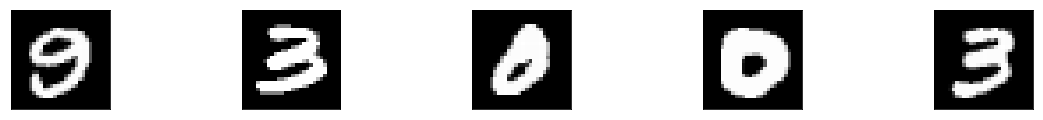

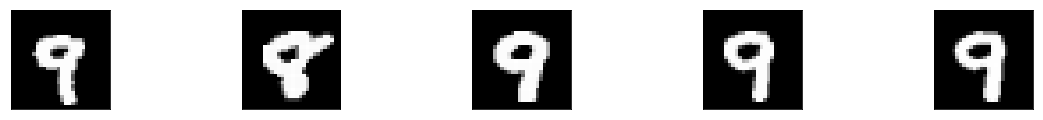

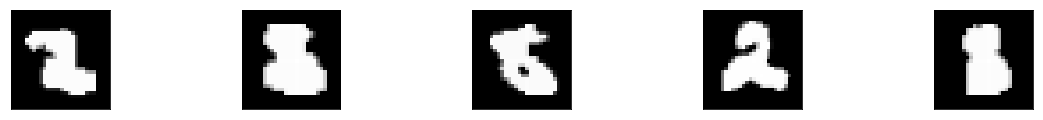

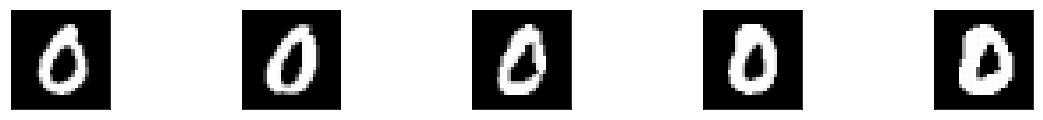

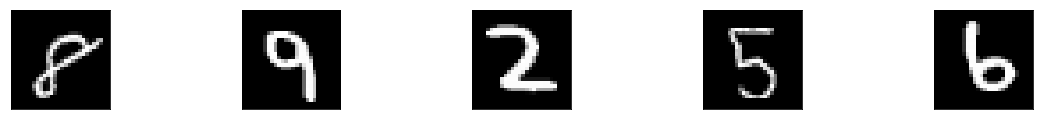

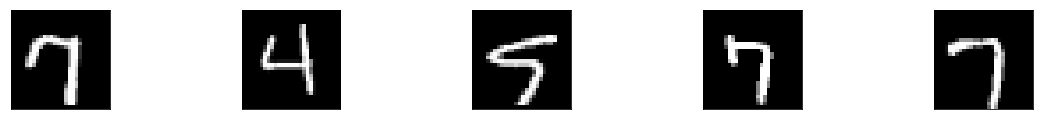

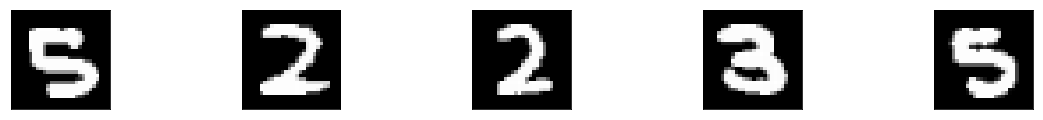

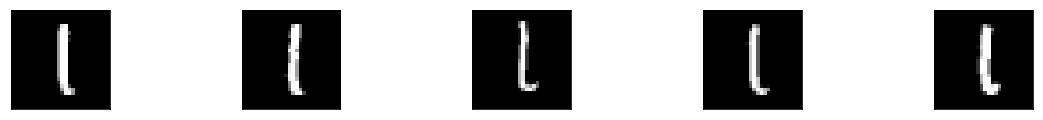

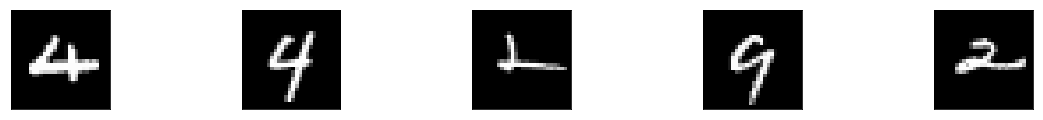

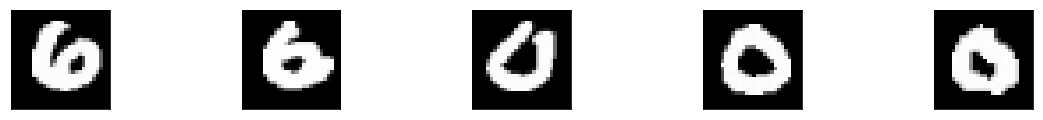

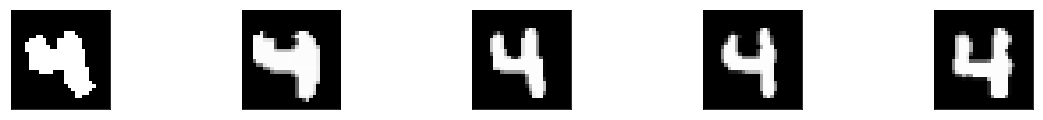

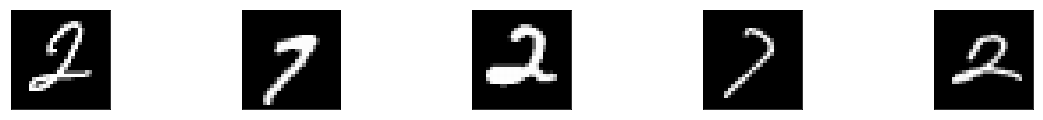

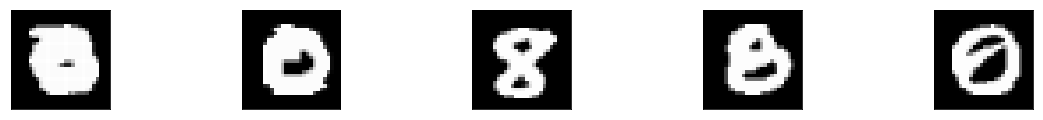

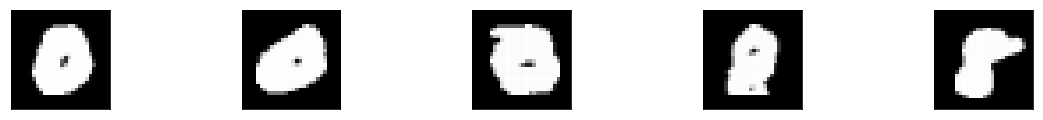

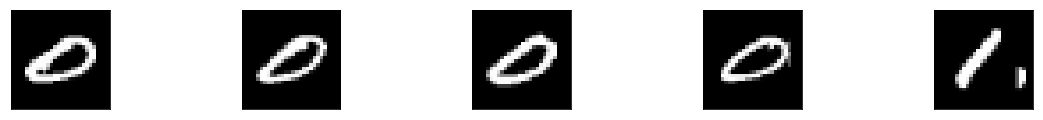

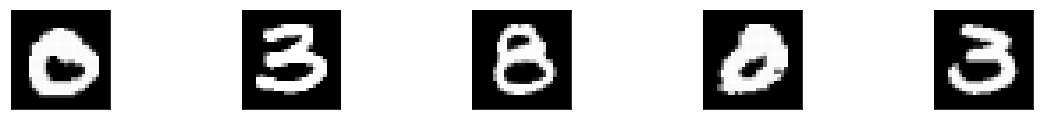

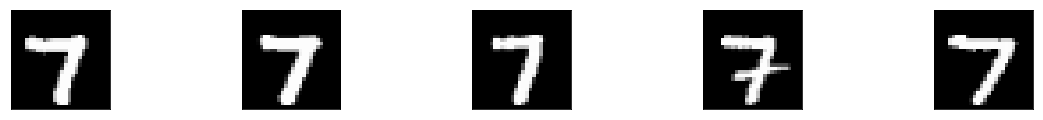

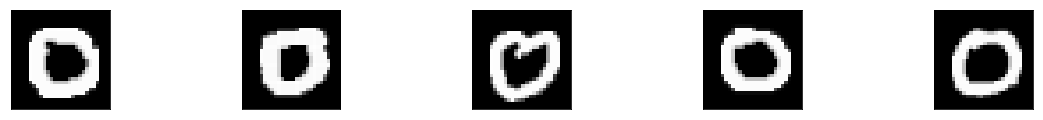

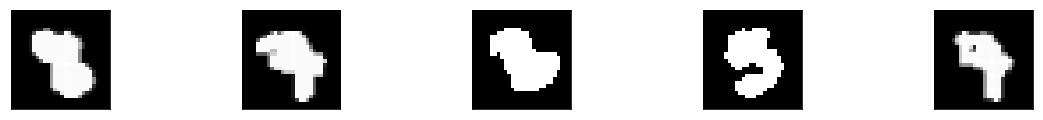

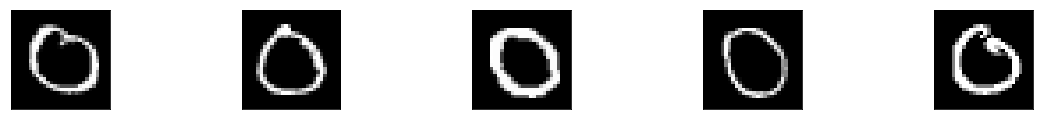

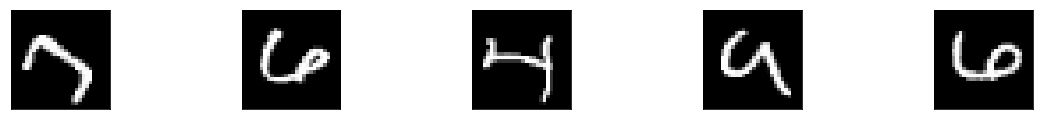

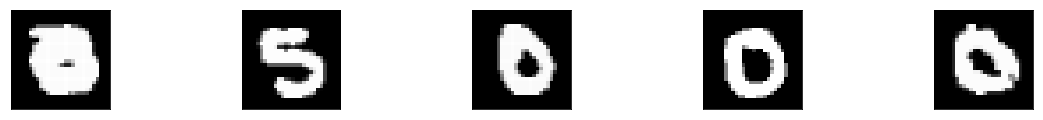

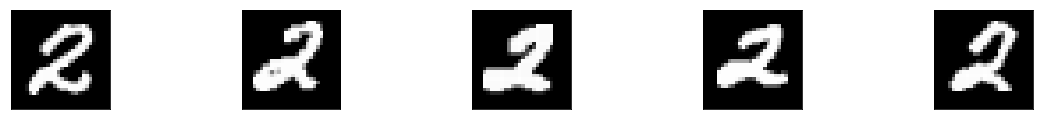

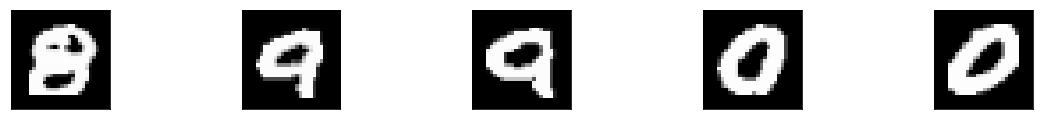

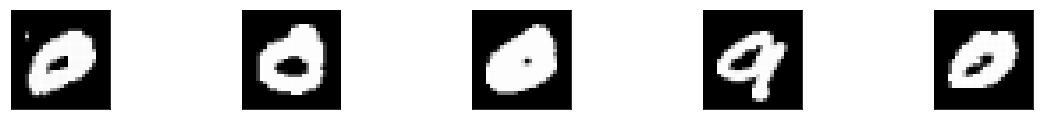

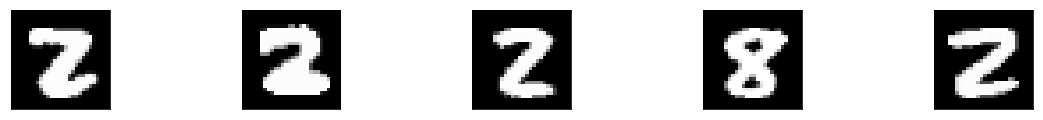

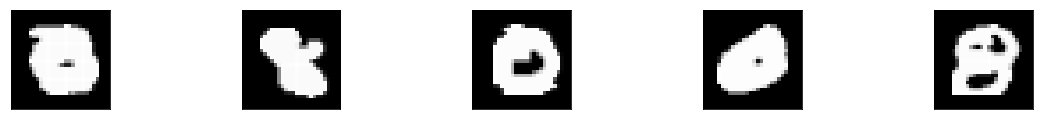

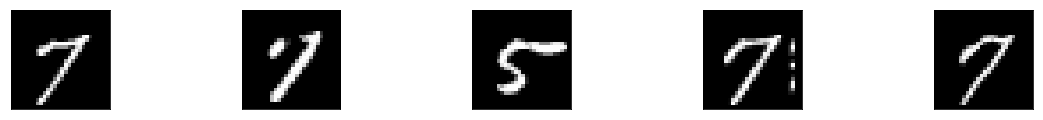

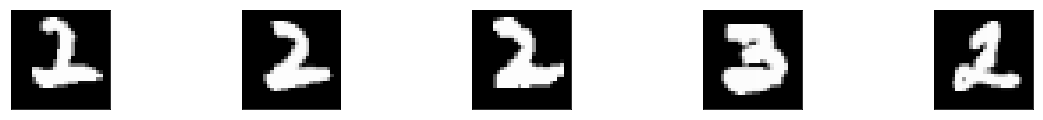

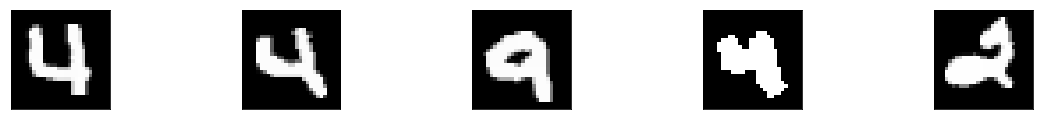

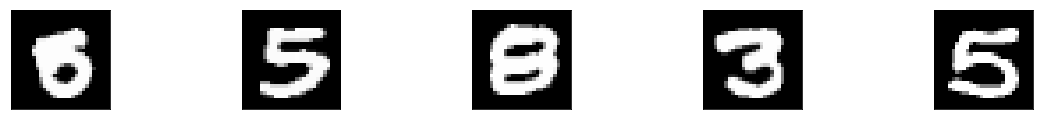

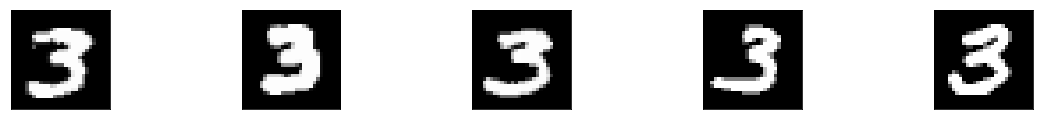

In [257]:
batch_size = 256
original_dim = 784
latent_dim = 32
nb_epoch = 100
n = 5

# preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
nb_classes = 10
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
Y_train = y_train
Y_test = y_test
y_train =  np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

# this is our input placeholder
input_img = Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encodedL1 = Dense(200, activation='relu', activity_regularizer=regularizers.l1(1e-8))(input_img)
encodedL2 = Dense(50, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL1)
encodedL3 = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(1e-8))(encodedL2)

# "decoded" is the lossy reconstruction of the input
decoded1 = Dense(50, activation='relu')(encodedL3)
decoded2 = Dense(100, activation='relu')(decoded1)
decoded = Dense(784, activation='linear')(decoded2)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encodedL3)
FirstLayer = Model(input=input_img, output=encodedL1)

autoencoder.compile(optimizer='adadelta', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

x_train_encoded_deep = encoder.predict(x_train, batch_size=batch_size)


for neuron in range(latent_dim):
    liste = np.argsort(x_train_encoded_deep[:, neuron])
    liste = liste[::-1]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_train[liste[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

## 4. Finding stimulus that fires most a hidden neuron by gradient descent

Ecrivez un code qui permet de déytermoner par descente de gradient l'entrée qui active le plus un neurone particulier d'une couche cachée.

Il vous faut:
i/ Définir une fonction du backend K par K.function qui prend en argument une donnée d'entrée  et retourne le loss et le gradient associé où le loss est l'activation de la cellule considérée 

ii/ Calculer le gradient par K.gradients 

iii/ Ecrire une boucle qui implémente la descente de gradient avec ce que vous venez d'écrire

iv/ Utiliser ce que vous venez de faire pour afficher l'image d'entrée qui active le plus chacun des neurones d'une couche cachée

In [240]:
layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
print (layer_dict)

{'dense_276': <keras.layers.core.Dense object at 0x7fbdf8b2eed0>, 'dense_277': <keras.layers.core.Dense object at 0x7fbdf8b3ac10>, 'dense_275': <keras.layers.core.Dense object at 0x7fc04f4fa410>, 'input_122': <keras.engine.topology.InputLayer object at 0x7fc04780a250>}


(1, 784)


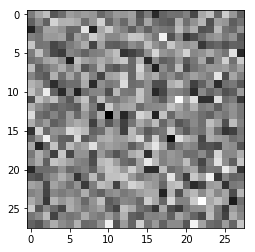

In [256]:
# Vous pouvez utiliser le code suivant pour accéder aux couches d'un réseau de neurones 

layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
# Choose the neuron you want to try
neuron = 10
input_img = encoder.input
layer_name = 'dense_276'
layer_output = layer_dict[layer_name].output
loss = layer_output[:, neuron]
grads = K.gradients(loss, input_img)[0]
iterate = K.function([input_img], [loss, grads])

# gradient step
step = 0.05
input_img_data = np.random.random((1, 784))
# number of iterations of gradient "increase"
for i in range(500):
    lossvalue, gradvalue = iterate([input_img_data])
    input_img_data = input_img_data + step*gradvalue

print (input_img_data.shape)
    
def preprocess_image(x):
    x = np.mean(x)
    x /= (np.std(x) + 0.0001)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.transpose((1, 2, 0))
    return x

#input_img_data = preprocess_image(input_img_data)
#print (input_img_data.shape)

plt.figure(figsize=(20, 4))
plt.imshow(input_img_data.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()


## 5. Denoising images

Autoencoders may be used to denoise input data. Denoising autoecnoders are godd at that but any autoencoder should be able to do so. You can test it with Mnist data by first generating a noisy version of these, then by looking at reconstructed data at the output of an autoencoder when fed with noisy mnist images.

i/ Explore the potential of autoencoders for this task.


## 6. Comparing variants of autoencoders as preprocessing models 

Compare variants of autoencoders to preprocess mnist data before usinga logitic regression classifier
 